# Building a Machine Learning Model  
---

## Introduction 

- In this notebook I will show you the basics of training a machine learning algorithm.  
  - For this example, we will perform __supervised learning__ by training __Support Vector Machines__, a common ML algorithm, __detect music genres from audio files__. 

- To train the models we will use two datasets consisting of audio features for the task of **genre classification**. 
  - The audio features are calculated from audio (.WAV) files using [Marsyas](http://marsyas.info/index.html#), an open source framework for audio analysis. 

- The first dataset contains just two song level features (average spectral centroid and average spectral rolloff). 
   - Using only two features we can directly visualize the data with a scatter plot. 
   - The points are colored in terms of their class membership.  

- The second dataset contains the same songs but with a set of 124 spectral features.

- There are three genres each represented by a 100 audio tracks or points in this case.
  - __classical, jazz and metal__. 

- Through the process we will get an intro to:
  - the ML pipeline
  - common ML tools (numpy, pandas, scikit-learn, matplotlib),
  - running a Jupyter Notebook (which will be needed later in the semester).

- We will use [scikit-learn](https://scikit-learn.org/stable/index.html)
  - a common ML framework for Python, to implement the ML pipeline. 

### Standard Imports

In [1]:
# Numpy for vector processing and linear algebra
import numpy as np

# Scikit learn for ML Pipeline
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import model_selection
from sklearn import metrics

# Matplotlib + Seaborn for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Panda for data processing
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Other Utils
from intro_ml_utils import make_mesh
from data.data_utils import get_doughnut_dataset

##  
---

## Data Generation

<img src="images/ml_pipeline_data.png" width=1200>

### Data Collection and Annotation

#### _Methods for Collection and Annotation_
- __Manual Annotation__
- __Empirical Studies / Experiments__
  - physiological measurements from the Trier Social Stress Test
- __Web Scraping__
  - search Google Images for pictures of specified facial expressions, such as _happy_ or _sad_
- __Historical Data and Records__
  - Risk assessment systems
- __Crowdsourcing__
  - [Amazon Mechanical Turk](https://onlinelibrary.wiley.com/doi/abs/10.1002/bdm.1753?casa_token=iW56bog9MJAAAAAA:BnSAAMDrpDFfnwMvphaHyfatw4W1f5q1RPT3KuhZitEYpNX1fDoBC7nRvNUvANvF5nFQvsO_d8WchavK)
  - [Data annotation games](https://www.cs.cmu.edu/~elaw/papers/ISMIR2007.pdf)
- __Existing Datasets__
  - [ImageNet](https://www.image-net.org/)
  
 __What are the potential issues with these methods for data collection?__
 
 ---

#### [GTZAN Music Genre Dataset](https://www.tensorflow.org/datasets/catalog/gtzan)

For this example we will use an existing dataset.

Tzanetakis et al. (2001) "Automatic Musical Genre Classification Of Audio Signals"

- Music selected from author's personal music library
- 1000 audio tracks, 30 seconds each
- 10 Genres, each with 100 tracks
  - blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock
  
(We're using a subset of 300 tracks from 3 genres: classical, metal and rock)
  
##### Feature Extraction

- Spectral analysis of raw audio file using Marsyas
- Our example dataset contains 124 spectral features describing audio content
  - including: time-domain Zero-Crossings, Spectral Centroid, Rolloff, Flux and Mel-Frequency Cepstral Coefficients (MFCC)
  
**_What are some potential causes of biases in this dataset?_**

#### Load Reduced Feature and Full Feature Datasets

In [2]:
# Load dataset with only two features for visualization
X_sm, y_sm = datasets.load_svmlight_file("data/3genres.arff.libsvm")
X_sm = X_sm.toarray()
print(f'X: Samples={X_sm.shape[0]}, Features={X_sm.shape[1]}')
print(f'y: Samples={y_sm.shape[0]}')

# save features and labels to Pandas dataframe for easier processing
target_names = ['classical', 'jazz', 'metal']
features_sm = ['centroid', 'rolloff']
label = 'genre'
df_sm = pd.DataFrame(data=X_sm, columns=features_sm)
df_sm[label] = y_sm

X: Samples=300, Features=2
y: Samples=300


In [3]:
# Load dataset with only with all features
X_full, y_full = datasets.load_svmlight_file("data/3genres_full.arff.libsvm")
X_full = X_full.toarray()
print(f'X: Samples={X_full.shape[0]}, Features={X_full.shape[1]}')
print(f'y: Samples={y_full.shape[0]}')

# save features and labels to Pandas dataframe for easier processing
target_names = ['classical', 'jazz', 'metal']
features_full = list(range(X_full.shape[1]))
label = 'genre'
df_full = pd.DataFrame(data=X_full, columns=features_full)
df_full[label] = y_full

X: Samples=300, Features=124
y: Samples=300


#### Review Datasets

In [4]:
df_sm.head()

,centroid,rolloff,genre
0,0.04040,0.01367,0.00000
1,0.03766,0.01253,0.00000
2,0.03572,0.01455,0.00000
3,0.04372,0.01943,0.00000
4,0.04766,0.01968,0.00000


In [5]:
df_full.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,genre
0,0.05118,0.04040,0.06487,0.09798,-56.20986,5.83262,-1.59563,0.30189,-0.02808,0.60366,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.27313,14.62464,0.00000
1,0.04580,0.03766,0.05608,0.09139,-58.20915,6.37194,-1.22784,0.07340,0.04066,0.94512,...,0.00001,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.23715,36.40195,0.00000
2,0.04722,0.03572,0.06051,0.10161,-54.71840,5.87012,-1.22444,0.38164,0.08155,0.92471,...,0.00002,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.26482,9.41532,0.00000
3,0.05634,0.04372,0.07720,0.09329,-58.10316,5.13522,-1.58811,0.64367,-0.02710,1.11544,...,0.00001,0.00001,0.00002,0.00003,0.00001,0.00000,0.00000,0.26283,9.48069,0.00000
4,0.05882,0.04766,0.08036,0.09979,-54.70623,5.20736,-1.32606,0.69685,-0.27829,0.42696,...,0.00001,0.00001,0.00002,0.00002,0.00001,0.00001,0.00001,0.28265,9.13761,0.00000


#### Review Datasets

In [6]:
df_sm[features_sm].describe()

,centroid,rolloff
count,300.00000,300.00000
mean,0.03794,0.07660
std,0.01679,0.06707
min,0.01094,0.00411
25%,0.02533,0.02495
50%,0.03315,0.05693
75%,0.04888,0.10812
max,0.10389,0.35726


In [7]:
df_full[features_full].describe()

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
count,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,...,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000,300.00000
mean,0.05389,0.03794,0.11868,0.10536,-53.64746,4.89649,-0.20655,1.32746,-0.06876,0.38634,...,0.00007,0.00008,0.00008,0.00008,0.00008,0.00008,0.00007,0.00007,0.16279,5.12350
std,0.02510,0.01679,0.07081,0.01142,6.54546,2.47612,0.91284,0.53391,0.36135,0.34456,...,0.00009,0.00010,0.00010,0.00010,0.00010,0.00010,0.00010,0.00010,0.07117,17.07572
min,0.01410,0.01094,0.02191,0.07758,-74.41200,0.37162,-3.18247,-0.45590,-1.79987,-0.82382,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.02820,0.11915
25%,0.03397,0.02533,0.06372,0.09761,-57.85861,2.65915,-0.94398,1.02378,-0.28086,0.15567,...,0.00002,0.00002,0.00002,0.00002,0.00002,0.00001,0.00001,0.00001,0.10809,0.66451
50%,0.04646,0.03315,0.10516,0.10681,-53.48756,5.07996,-0.16906,1.28320,-0.09214,0.36167,...,0.00004,0.00004,0.00004,0.00004,0.00004,0.00004,0.00003,0.00003,0.15309,1.48732
75%,0.07330,0.04888,0.16386,0.11412,-48.47865,6.82161,0.43485,1.65675,0.13995,0.59060,...,0.00009,0.00010,0.00010,0.00009,0.00009,0.00008,0.00008,0.00008,0.20129,4.22292
max,0.14225,0.10389,0.57170,0.13242,-42.21521,10.57150,2.05170,3.17329,1.09607,1.32804,...,0.00051,0.00053,0.00054,0.00054,0.00054,0.00054,0.00053,0.00052,0.43053,251.41557


### Data Preperation / Preprocessing

##### __Data Processing__

- standardizing and normalizing data
- feature extraction (grey line between data collection and processing)
- data augmentation
- Feature Selection or Dimensionality Reduction
  - [Principal Component Analysis](https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca)
  - [t-SNE or Manifold Learning](https://scikit-learn.org/stable/modules/manifold.html)

##### __Data Preperation__
- Reviewing and cleaning data samples
- Balancing Data
  - Downsampling
  - Upsampling
  - [imbalanced-learn](https://imbalanced-learn.org/stable/)
     - SMOTE for upsampling through synthetic data generation
- Spliting data into Training, Testing and Validation (common for deep learning) datasets

#### Min Max Scaling

Scale each feature, $i$, to range $[min, max]$, using following formula:

scale between $[0, 1]$
$$
    x_i^{\prime} = \dfrac{x_i - min(x_i)}{max(x_i) - min(x_i)}
$$

then scale to arbitrary min-max values in range $[min, max]$
$$
    x_i^{\prime} = x_i^{\prime} * (max - min) + min
$$

In [8]:
minmax_scaler = preprocessing.MinMaxScaler()  # default range [0, 1] can change using feature_range=(-1, 1)
minmax_scaler.fit(df_sm[features_sm])
X_minmax = minmax_scaler.transform(df_sm[features_sm])

In [9]:
X_minmax = pd.DataFrame(data=X_minmax, columns=features_sm)
X_minmax.describe()

,centroid,rolloff
count,300.00000,300.00000
mean,0.29048,0.20527
std,0.18066,0.18991
min,0.00000,0.00000
25%,0.15485,0.05902
50%,0.23897,0.14959
75%,0.40825,0.29453
max,1.00000,1.00000


#### Standardize Data or Zero Mean Unit Variance Normalization

Removes the mean of the data and scales to have unit variance

$$
    x_i^{\prime} = \dfrac{x_i - \mu_i}{\sigma_i}
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation of feature $i$

In [10]:
standard_scaler = preprocessing.StandardScaler()
X_zmuv = standard_scaler.fit_transform(df_sm[features_sm])

In [11]:
X_zmuv = pd.DataFrame(data=X_zmuv, columns=features_sm)
X_zmuv.describe()

,centroid,rolloff
count,300.00000,300.00000
mean,0.00000,-0.00000
std,1.00167,1.00167
min,-1.61056,-1.08267
25%,-0.75203,-0.77140
50%,-0.28563,-0.29368
75%,0.65296,0.47081
max,3.93385,4.19172


####  
---

#### Train/Test Split

- Split dataset into train and testing sets
- apply normalization preprocessing to datasets

In [12]:
# get features and labels from original df
# small dataset
X = np.array(df_sm[features_sm])
y = np.array(df_sm[label])

# full dataset
# X = np.array(df_full[features_full])
# y = np.array(df_full[label])

# Split the data for training and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.25, random_state=5)

# initialize and fit scaler to training data
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

# scale training and testing data using scaler fit on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training Data')
print(f'X: {X_train.shape}, y: {y_train.shape}')
print('Test Data')
print(f'X: {X_test.shape}, y: {y_test.shape}')

Training Data
X: (225, 2), y: (225,)
Test Data
X: (75, 2), y: (75,)


In [13]:
# Training Data Statistics
df_tmp = pd.DataFrame(X_train)
df_tmp.describe()

,0,1
count,225.00000,225.00000
mean,0.35942,0.19952
std,0.22468,0.18727
min,0.00000,0.00000
25%,0.18424,0.05691
50%,0.29570,0.14409
75%,0.51201,0.29458
max,1.00000,1.00000


In [14]:
# Test Data Statistics
df_tmp = pd.DataFrame(X_test)
df_tmp.describe()

,0,1
count,75.00000,75.00000
mean,0.36087,0.21458
std,0.22248,0.20033
min,0.03758,-0.00250
25%,0.20734,0.05622
50%,0.30066,0.15097
75%,0.48773,0.28432
max,1.23857,0.99797


#### Questions
1. Why is it important to scale/normalize the test data scaled separately with training data statistics?
2. What is the problem with splitting the data randomly? 
    - How can this be addressed?

##  
---

## Model Training  

<img src="images/ml_pipeline_models.png" width=1200>

### Model Development

##### 1. Model Type and Architecture

- Depends on Task, _T_
    - Classification, Regression, Clustering, etc...
- Model Type
    - Classical ML
        - Support Vector Machines, Linear or Logistic Regression, Decision Trees, etc...
    - Deep Learning
        - Feedfordward network, Convolutional Network, ResNet, Transformers, etc...

##### 2. Hyperparameter selection

- A parameter of selected model and architecture that affects the learning process
- Used to tuning the model training process

##### 3. Perform Training

---

#### Create and Train SVMs with different Kernels

A support vector machine (SVM) is a linear model that supports non-linear datasets through the [kernel trick](http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html) 
- (also see optional section, _More on SVMs Maximum Margin Seperating Hyperplane_, below).

Scikit-Learn Support Vector Machine Implementations

- [Support Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Linear Suppor Vector Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)



#### Hyperparameter Selection and Model Training

In [15]:
kernels = ["linear", "rbf", "poly"]
C = .3 # regularization parameter
poly_degree = 3 # polynomial order for the poly kernel (affects capacity)

clfs = {
    "SVC w/ Linear Kernel": svm.SVC(kernel="linear", C=C),
    "LinearSVC": svm.LinearSVC(C=C),
    "SVC w/ RBF Kernel": svm.SVC(kernel="rbf", C=C),
    "SVC w/ 3 Degree Polynomial kernel": svm.SVC(kernel="poly", degree=poly_degree, C=C)
}

In [16]:
#train the models
models = {title: clf.fit(X_train, y_train) 
          for title, clf in clfs.items()}

#### Plot the Models

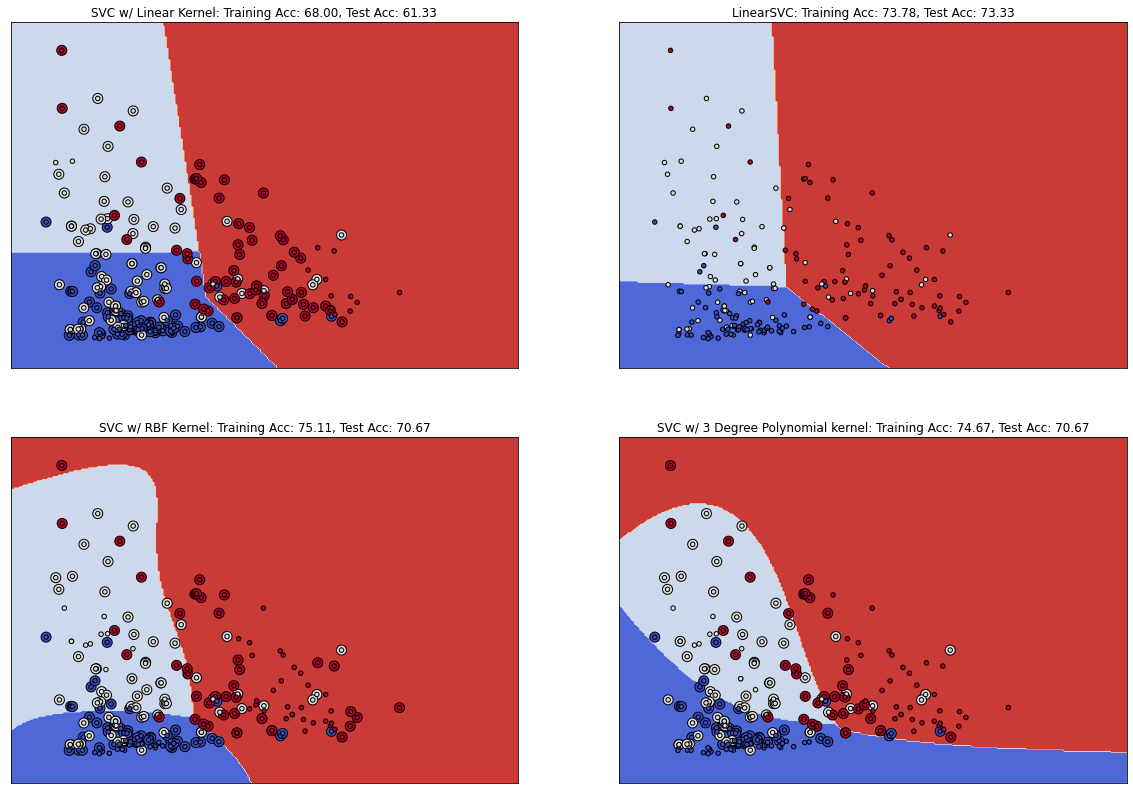

In [17]:
fig, sub = plt.subplots(2,2, figsize=(20, 14))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# make mesh for plotting
X_normed = scaler.transform(X) # scale X to ensure mesh has correct bounds
xx, yy = make_mesh(X_normed[:, 0], X_normed[:, 1], padding=.1, h=.005)

for (title, clf), ax in zip(models.items(), sub.flatten()):
    
    # predict all points on mesh for plotting decision boundries
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Evaluate models
    test_score = clf.score(X_test, y_test)
    train_score = clf.score(X_train, y_train)
    
    # plot training or testing data
    ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.coolwarm, zorder=11, edgecolor='k', s=20)
#     ax.scatter(X_test[:,0], X_test[:,1], c=y_test, s=50, zorder=10, edgecolor='k',cmap=plt.cm.coolwarm)

    # get support samples if supported by classifier (not supported by LinearSVC)
    if title != "LinearSVC":
        sv = clf.support_
        X_support = X_train[sv]
        y_support = y_train[sv]
        ax.scatter(X_support[:,0], X_support[:, 1], c=y_support, cmap=plt.cm.coolwarm, 
                   s=100, zorder=10, edgecolor='k')

    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
    ax.set_title(f'{title}: Training Acc: {train_score*100:.2f}, Test Acc: {test_score*100:.2f}')
    ax.set_xticks(())
    ax.set_yticks(())

### Model Evaluation

- Evaluation models for with the goal of ___generalizability___
- Metric selection typically depends on task

##### __Some common metrics are:__
- __Accuracy:__ percent of correctly labeled predictions
  - $acc = \dfrac{correct \: preds}{total \: preds}$
  - $er =  1 - acc$
- __Precision:__ proportion of positively labeled predictions that are correct
  - $ precision = \dfrac{tp}{tp + fp} $  
- __Recall:__ proportion of actual positives that are identified correctly
  - $ recall = \dfrac{tp}{tp + fn} $  
- __F1 Score:__ harmonic average of precision and recall
  - $ F_{score}= 2 * \dfrac{precision * recall}{precision + recall} $  
  
  
##### __Confusion Matrics__

- Matrix of actual vs. predicted labels for each class
- Provides further intuition as to where model is confused

---

#### Evaluate Trained SVMs


[sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification%20report#sklearn.metrics.classification_report)

In [18]:
for title, model in models.items():
    y_pred = model.predict(X_test)
    print(title)
    print(metrics.classification_report(y_test, y_pred, target_names=target_names))
    print()

SVC w/ Linear Kernel
              precision    recall  f1-score   support

   classical       0.55      0.88      0.68        24
        jazz       0.50      0.35      0.41        23
       metal       0.81      0.61      0.69        28

    accuracy                           0.61        75
   macro avg       0.62      0.61      0.59        75
weighted avg       0.63      0.61      0.60        75


LinearSVC
              precision    recall  f1-score   support

   classical       0.67      0.83      0.74        24
        jazz       0.74      0.61      0.67        23
       metal       0.81      0.75      0.78        28

    accuracy                           0.73        75
   macro avg       0.74      0.73      0.73        75
weighted avg       0.74      0.73      0.73        75


SVC w/ RBF Kernel
              precision    recall  f1-score   support

   classical       0.65      0.71      0.68        24
        jazz       0.68      0.65      0.67        23
       metal       0.78 

#### Plot Confusion Matrices

[sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

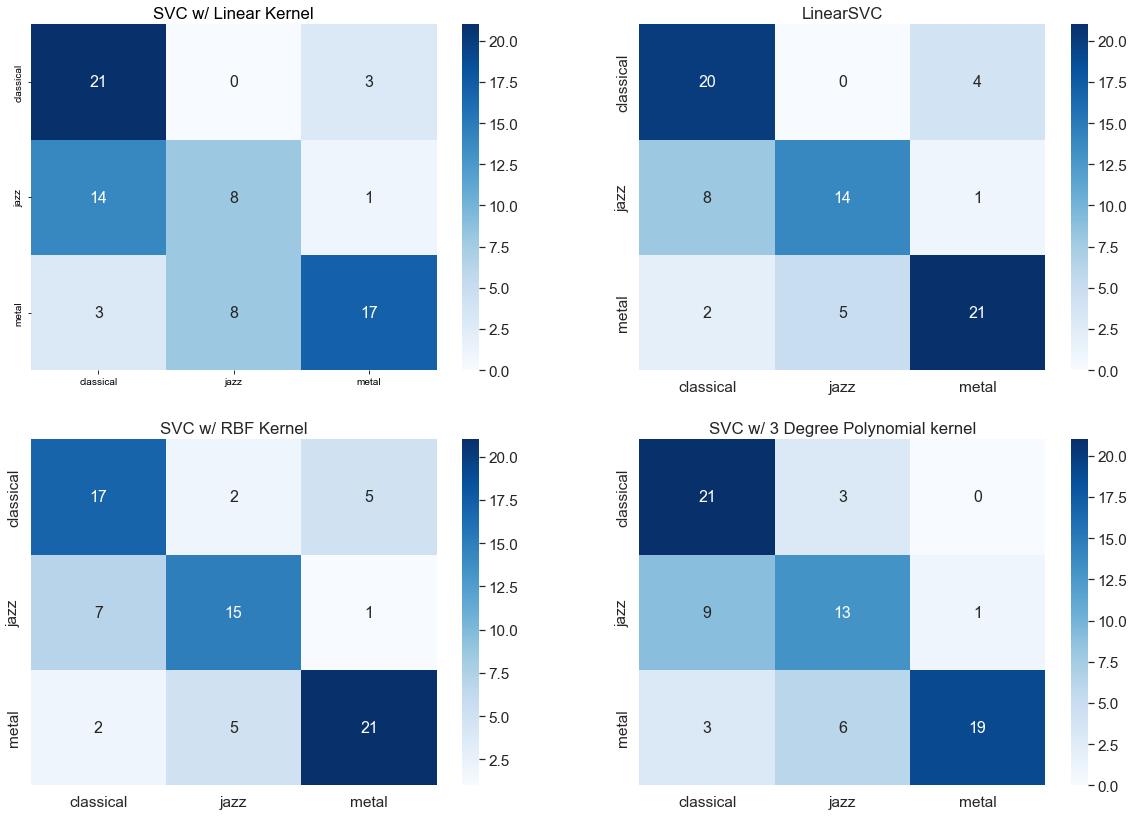

In [19]:
plt.figure(figsize=(20, 14))
for i, (title, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.subplot(2, 2, i+1)
    
    df_cm = pd.DataFrame(cm, range(3), range(3))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues',
                xticklabels=target_names, yticklabels=target_names) # font size
    plt.title(title)

#### Cross Validation with Hyperparameter Optimization

A better method for selecting and evaluating models

Here we will use scikit-learn's Pipeline and GridSearchCV methods to find optimal hyperparameters:  
- [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  
- [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

##### Other Methods:  
- [Randomized search and other scikit-learn methods](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers)    
- [AutoML](https://www.automl.org/automl/)  
- [Hyperopt: Distributed Hyperparameter Optimization](https://github.com/hyperopt/hyperopt)  
- [Baysian Optimization](https://github.com/fmfn/BayesianOptimization)  

In [20]:
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass
    
# Define Hyperparameters
C = [0.1, 1, 10]
gamma = ['auto', 'scale', 0.005, 0.01, 0.1]
poly_degree = [2, 3, 5]

# Setup Training Pipeline
scaler = preprocessing.MinMaxScaler()
pipeline = Pipeline([('scaler', preprocessing.MinMaxScaler()), ('clf', DummyEstimator())])

# Create Search Space
search_space = [
    {
        'clf': [svm.LinearSVC()],
        'clf__C': C
    },
    {
        'clf': [svm.SVC()],
        'clf__kernel': ['linear'],
        'clf__C': C
    },
    {
        'clf': [svm.SVC()],
        'clf__kernel': ['rbf'],
        'clf__C': C,
        'clf__gamma': gamma,
    },
    {
        'clf': [svm.SVC()],
        'clf__kernel': ['poly'],
        'clf__C': C,
        'clf__gamma': gamma,
        'clf__degree': poly_degree
    }
]

# set up 5 fold cross validation
clf = GridSearchCV(estimator=pipeline, param_grid=search_space, cv=5, verbose=1, scoring='f1_macro')


In [21]:
clf = clf.fit(X_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting 5 folds for each of 66 candidates, totalling 330 fits
Best estimator found by grid search:
Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', SVC(C=10))])


In [22]:
df = pd.DataFrame(clf.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,param_clf__kernel,param_clf__gamma,param_clf__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00149,0.00060,0.00123,0.00064,LinearSVC(),0.10000,NaN,NaN,NaN,"{'clf': LinearSVC(), 'clf__C': 0.1}",0.69421,0.66443,0.69433,0.63035,0.75790,0.68824,0.04206,16
1,0.00178,0.00026,0.00100,0.00028,LinearSVC(),1,NaN,NaN,NaN,"{'clf': LinearSVC(), 'clf__C': 1}",0.75878,0.66436,0.73563,0.64858,0.77937,0.71734,0.05183,5
2,0.00755,0.00084,0.00106,0.00014,LinearSVC(),10,NaN,NaN,NaN,"{'clf': LinearSVC(), 'clf__C': 10}",0.75878,0.69190,0.67024,0.64858,0.77937,0.70977,0.05074,10
3,0.00227,0.00042,0.00118,0.00017,SVC(),0.10000,linear,NaN,NaN,"{'clf': SVC(), 'clf__C': 0.1, 'clf__kernel': '...",0.35556,0.31633,0.35688,0.30303,0.38791,0.34394,0.03057,26
4,0.00182,0.00029,0.00120,0.00010,SVC(),1,linear,NaN,NaN,"{'clf': SVC(), 'clf__C': 1, 'clf__kernel': 'li...",0.71832,0.67507,0.63951,0.66309,0.78183,0.69557,0.05015,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.00206,0.00032,0.00113,0.00017,SVC(),10,poly,auto,5,"{'clf': SVC(), 'clf__C': 10, 'clf__degree': 5,...",0.25578,0.17089,0.33868,0.15819,0.13095,0.21090,0.07631,31
62,0.18612,0.09094,0.00117,0.00016,SVC(),10,poly,scale,5,"{'clf': SVC(), 'clf__C': 10, 'clf__degree': 5,...",0.61752,0.64144,0.70513,0.63833,0.54610,0.62970,0.05107,21
63,0.00217,0.00046,0.00112,0.00016,SVC(),10,poly,0.00500,5,"{'clf': SVC(), 'clf__C': 10, 'clf__degree': 5,...",0.11111,0.13095,0.12121,0.15819,0.13095,0.13048,0.01568,32
64,0.00208,0.00013,0.00133,0.00035,SVC(),10,poly,0.01000,5,"{'clf': SVC(), 'clf__C': 10, 'clf__degree': 5,...",0.11111,0.13095,0.12121,0.15819,0.13095,0.13048,0.01568,32


##### Review Results of Best Classifier

In [23]:
print(f'Train Acc = {clf.score(X_train, y_train):.03f}')
print(f'Test Acc =  {clf.score(X_test, y_test):.03f}')

Train Acc = 0.777
Test Acc =  0.716


In [24]:
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   classical       0.70      0.67      0.68        24
        jazz       0.67      0.70      0.68        23
       metal       0.79      0.79      0.79        28

    accuracy                           0.72        75
   macro avg       0.72      0.72      0.72        75
weighted avg       0.72      0.72      0.72        75



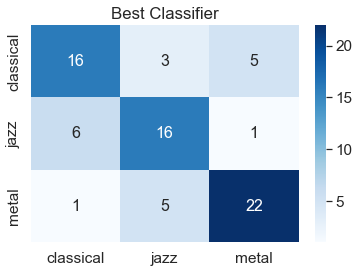

In [25]:
cm = metrics.confusion_matrix(y_test, y_pred)

    
df_cm = pd.DataFrame(cm, range(3), range(3))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues',
            xticklabels=target_names, yticklabels=target_names) # font size
_ = plt.title('Best Classifier')

#### More on SVMs Maximum Margin Seperating Hyperplane (Optional)

In [26]:
X_blobs, y_blobs = make_blobs(n_samples=40, centers=2, random_state=6)
X_doughnut, y_doughnut, _, _ = get_doughnut_dataset()

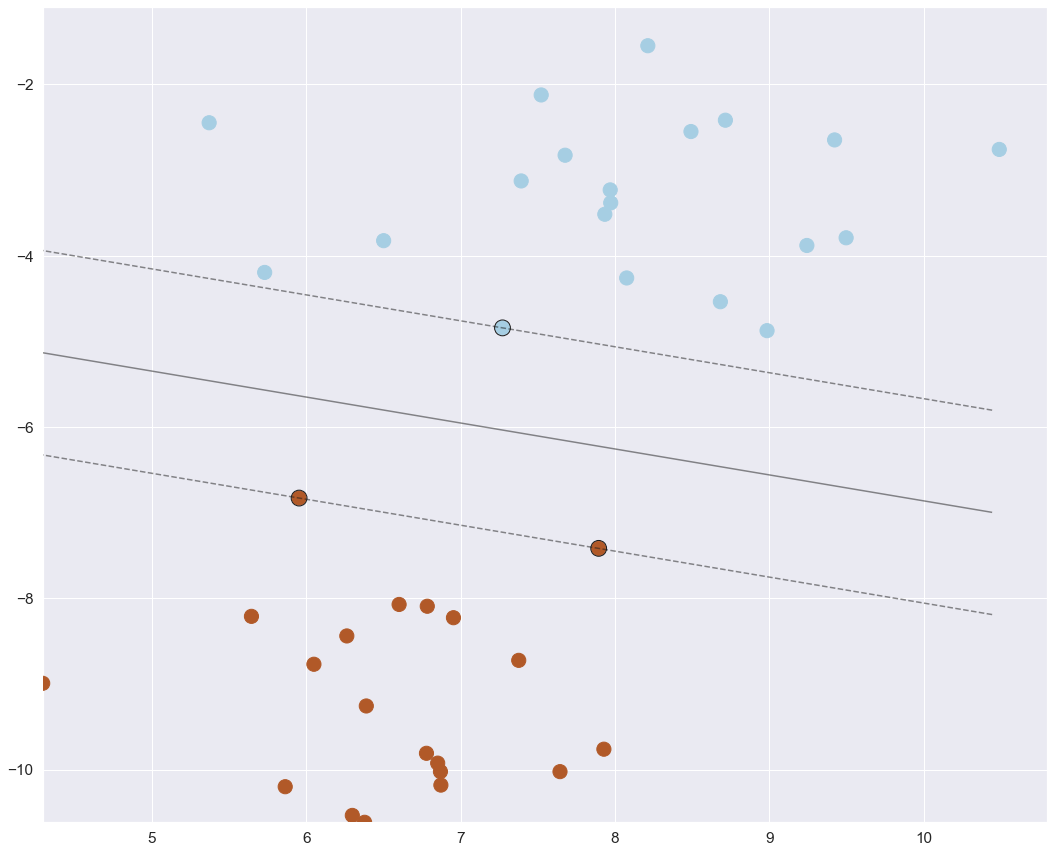

In [27]:
# X, y = X_doughnut, y_doughnut
X, y = X_blobs, y_blobs

# fit the model, don't regularize 
clf = svm.SVC(kernel='linear', C=1) ## Try with different Kernels
clf.fit(X, y)

plt.figure(figsize=(18, 15))
plt.scatter(X[:, 0], X[:, 1], c=y, s=200, cmap=plt.cm.Paired, zorder=10)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx, yy = make_mesh(X[:, 0], X[:, 1], padding=0, h=.05)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot decision boundary and margins
ax.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, colors='k',
           linestyles=['--', '-', '--'], zorder=11)
# # plot support vectors
sc = ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=250,
           linewidth=1, facecolors='none', edgecolor='k', zorder=10)

### Model Postprocessing

##### __Postprocessing__

- Selection of probablity (or score) threshold for final class determination
  - often a tradeoff between precision and recall
- Ensemble Aggregration
- Sample Aggregation
  - Majority voting vs. Max Value vs. Average
  
_Genre Classification Example of Sample Aggregation_

- Instead of one feature vector per 30 second clip, we extract features every 5 seconds for training
- How do we aggregate the results of all 6 clips into a final score?

### Model Deployment

##### __Challenges in Real World Deployment__

- Real world setting vs. data collection setting
    - Domain Shift / Data Drift
- Deployment Requirements
    - Explainabilty
    - Latency vs. Real-time feedback
- Unintended or undesired uses